In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse.linalg as spLA
import numpy.linalg as LA

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Message Kernels

In [2]:
# Reply Kernel
def p_reply(sender, replier, scale, shift):
    logodds = np.log(scale/(1-scale))
    score = sender - replier + shift
    return 1/(1 + np.exp(-logodds * score))

# First Message Kernel
def kern(sender,receiver,scale,shift):
    logodds = np.log(scale/(1-scale))
    score = sender - receiver + shift
    return 1/(1 + np.exp(-logodds * score))

def p_first(sender, receiver, Lscale, Lshift, Rscale, Rshift):
    a = kern(sender,receiver,Lscale,Lshift)
    b = kern(sender,receiver,Rscale,Rshift)
    return a*b

## Simulation

In [21]:
# Reply Kernel with discrimination
def p_reply_disc(sender, replier, scale, shift, preference):
    logodds = np.log(scale/(1-scale))
    score = (sender + preference) - replier + shift
    return 1/(1 + np.exp(-logodds * score))

In [135]:
# N total (divisible by 2)
N = 1000
N_men = N // 2
N_women = N // 2

# Generate ranks
# s_men = np.random.uniform(low=1, high=10, size=N_men)
# s_women = np.random.uniform(low=1, high=10, size=N_women)
s_men = np.random.normal(0, 1, size=N_men)
s_women = np.random.normal(0, 1, size=N_women)

# slopes
discrimination = 0.8
realism = 0.8

# shifts
delusion = 1
ambition = 3

# Assign groups
num_groups_men = 4
num_groups_women = 4
g_men = np.random.randint(0, num_groups_men, size=N_men)
g_women = np.random.randint(0, num_groups_women, size=N_women)

# Construct G_m matrix for men
G_m = np.zeros((N_men, num_groups))
for man_id, group_id in enumerate(g_men):
    G_m[man_id, group_id] = 1

# discrimination
group_pref = np.abs(np.random.normal(0, 1))
group_disc = np.abs(np.random.normal(0, 1))

Theta = np.zeros((num_groups_women, num_groups_men))
for i in range(num_groups_women):
    Theta[num_groups_women-1, i] = -group_disc
    Theta[i, i] = group_pref # overwrite for last group
    
# Theta = np.random.randint(-group_disc, group_pref, size=(num_groups, num_groups))

In [136]:
print(Theta)

[[ 0.0109401   0.          0.          0.        ]
 [ 0.          0.0109401   0.          0.        ]
 [ 0.          0.          0.0109401   0.        ]
 [-0.16330336 -0.16330336 -0.16330336  0.0109401 ]]


In [149]:
msg_first = np.zeros([N_men,N_women])
list_first = []
for idxman,man in enumerate(s_men):
    for idxwoman,woman in enumerate(s_women):
        # is there a message?
#         pr = p_first(man,woman,
#                          Lscale=1-discrimination,
#                          Lshift=delusion,
#                          Rscale=realism,
#                          Rshift=ambition)
        pr = 0.5
        msg_first[idxman,idxwoman] = np.random.binomial(1, pr)
        if msg_first[idxman,idxwoman]==1:
            list_first.append([idxman,idxwoman])

print("There were {:.0f} first messages sent. ({:.1f}%)".format(
        np.sum(msg_first),
        100*np.sum(msg_first)/(N_men*N_women)))

There were 125466 first messages sent. (50.2%)


In [150]:
msg_reply = np.zeros([N_men,N_women])
list_reply = []
for first in list_first:
    # is there a reply?
    idxman = first[0]
    idxwoman = first[1]
    pr = p_reply_disc(s_men[idxman],s_women[idxwoman],
                      scale=discrimination,
                      shift=-delusion,
                      preference=Theta[g_women[idxwoman], g_men[idxman]])
    msg_reply[idxman,idxwoman] = np.random.binomial(1, pr)
    if msg_reply[idxman,idxwoman]==1:
        list_reply.append([idxman,idxwoman])
        
print("There were {:.0f} replies. ({:.1f}%)".format(
        np.sum(msg_reply),
        100*np.sum(msg_reply)/np.sum(msg_first)))

There were 37769 replies. (30.1%)


## Extract hierarchy

In [152]:
# All the data that we need are in:
# list_first[idxman,idxwoman]
# list_reply[idxman,idxwoman]

# Prep
first = np.array(list_first)
reply = np.array(list_reply)

# Get the list of women who replied to anyone. This basically ends up being everyone...
arbiters = np.unique(reply[:,1])

# For each woman, determine who did not get a reply, and who did get a reply
A = np.zeros([N_men,N_men],dtype=int)
A_t = []
for i in range(num_groups_women):
    A_t.append(np.zeros([N_men, N_men]))

for a in arbiters:
    group_id = g_women[a]
    gotReply = reply[reply[:,1]==a][:,0]
    sentFirst = first[first[:,1]==a][:,0]
    gotSilence = np.setdiff1d(sentFirst,gotReply)
    for winner in gotReply:
        for loser in gotSilence:
            A[winner,loser] += 1
            A_t[group_id][winner, loser] += 1

## Groups

In [153]:
l_a = 5e-2
l_b = [5e-1, 2e-2, 1e-1, 3e-2]

# Construct full Laplacian
N = A.shape[0]
k_in = np.sum(A, 0)
k_out = np.sum(A, 1)
L = np.diag(k_out + k_in) - (A + A.T)

# Construct group Laplacians
L_t = []
k_t_in = []
k_t_out = []
for A_r in A_t:
    N_r = A_r.shape[0]
    k_r_in = np.sum(A_r, 0)
    k_r_out = np.sum(A_r, 1)
    L_r = np.diag(k_r_out + k_r_in) - (A_r + A_r.T)
    
    L_t.append(L_r)
    k_t_in.append(k_r_in)
    k_t_out.append(k_r_out)

# Row 1
LHS = L #+ l_a*np.eye(N_men)
for L_r in L_t:
    LHS = np.concatenate((LHS, np.matmul(L_r, G_m)), axis=1)
RHS = k_out - k_in

filler_matrix = np.zeros((num_groups_men, num_groups_men))

# Row n
for i, L_r in enumerate(L_t):
    compressed = np.matmul(G_m.T, L_r)
    row_n = compressed
    block = np.matmul(compressed, G_m) #+ l_b[i]*np.eye(num_groups)
    for j in range(num_groups_women):
        if i == j:
            row_n = np.concatenate((row_n, block), axis=1)
        else:
            row_n = np.concatenate((row_n, filler_matrix), axis=1)
    LHS = np.concatenate((LHS, row_n), axis=0)
    RHS = np.concatenate((RHS, np.matmul(G_m.T, k_t_out[i] - k_t_in[i])), axis=0)

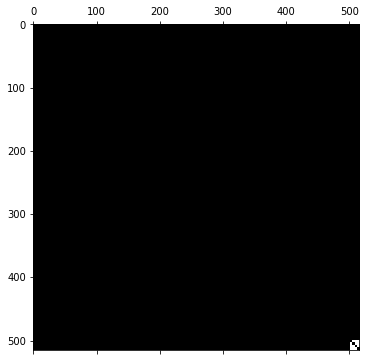

In [154]:
plt.figure(figsize=(6,6))
plt.spy(LHS)
# plt.spy(LHS[500:,500:])
plt.show()

In [155]:
output = spLA.bicgstab(LHS, RHS)
x = output[0]
print(x.shape)

(516,)


In [156]:
s_est = x[:N_men]
Theta_est = np.zeros((num_groups_women, num_groups_men))
for r in range(num_groups_women):
    start_idx = N_men + (r*num_groups_men)
    end_idx = N_men + (r*num_groups_men) + num_groups_men
    theta_r = x[start_idx:end_idx]
    for s, val in enumerate(theta_r):
        Theta_est[r, s] = val

In [157]:
print(Theta_est)

[[-0.01060371  0.0419492  -0.02715119 -0.00419429]
 [-0.01177575  0.04027194 -0.03334561  0.00484942]
 [-0.01995036  0.05535807 -0.03437323 -0.00103448]
 [-0.04691472  0.02099455 -0.03913182  0.06505199]]


In [158]:
print(Theta)

[[ 0.0109401   0.          0.          0.        ]
 [ 0.          0.0109401   0.          0.        ]
 [ 0.          0.          0.0109401   0.        ]
 [-0.16330336 -0.16330336 -0.16330336  0.0109401 ]]


In [159]:
s_est = tl.adjust_ranks(s_est, A, p_ij=0.8, least_rank=0)

s_est_g = s_est - np.matmul(G_m, Theta_est.sum(axis=0))
s_est_g = tl.adjust_ranks(s_est_g, A, p_ij=0.8, least_rank=1)

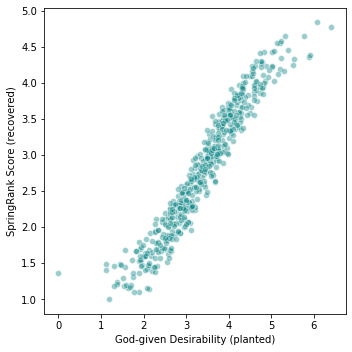

In [162]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(s_men - np.min(s_men), s_est_g,
           alpha=0.4,
           color='teal',
           edgecolor='white',
           label='{:.0f} first msgs, {:.0f} replies'.format(np.sum(msg_first),np.sum(msg_reply))
          )
ax.set_xlabel('God-given Desirability (planted)')
ax.set_ylabel('SpringRank Score (recovered)')
# ax.set_square()
# ax.set_aspect('equal', 'box')
# ax.set_ylim([1,10])
# ax.set_xlim([1,10])
plt.tight_layout()

In [345]:
temperature = tl.get_temperature(s_est, A, p_ij=0.8, interval=(0.01, 20))

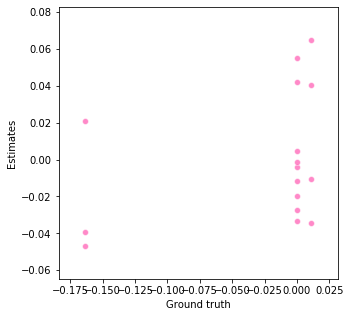

In [161]:
scale = 1
# shift = np.array([-4, 3, 0, 4]).T
shift = -np.min(Theta_est, axis=0)

plt.figure(figsize=(5,5))
plt.scatter(Theta.flatten(),
            scale * (Theta_est).flatten(),
           alpha=0.5,
           color='deeppink',
           edgecolor='white')

# plt.scatter(Theta.sum(axis=0),
#             Theta_est.sum(axis=0),
#            alpha=0.5,
#            color='deeppink',
#            edgecolor='white')


plt.xlabel("Ground truth")
plt.ylabel("Estimates")

plt.show()